# Advanced dynamic seq2seq with TensorFlow

Encoder is bidirectional now. Decoder is implemented using `tf.nn.raw_rnn`. 
It feeds previously generated tokens during training as inputs, instead of target sequence.

**UPDATE (16.02.2017)**: I learned some things after I wrote this tutorial. In particular:
 - [DONE] Replacing projection (one-hot encoding followed by linear layer) with embedding (indexing weights of linear layer directly) is more efficient.
 - When decoding, feeding previously generated tokens as inputs adds robustness to model's errors. However feeding ground truth speeds up training. Apperantly best practice is to mix both randomly when training.

I will update tutorial to reflect this at some point.

In [1]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
tf.__version__

'1.9.0'

In [3]:
PAD = 0
EOS = 1

vocab_size = 259
input_embedding_size = 100

encoder_hidden_units = 100
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

Previously we elected to manually feed `decoder_inputs` to better understand what is going on. Here we implement decoder with `tf.nn.raw_rnn` and will construct `decoder_inputs` step by step in the loop.

## Embeddings
Setup embeddings (see tutorial 1)

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

## Encoder

We are replacing unidirectional `tf.nn.dynamic_rnn` with `tf.nn.bidirectional_dynamic_rnn` as the encoder.


In [6]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [8]:
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead


In [9]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 100) dtype=float32>

In [10]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 100) dtype=float32>

In [11]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_4:0' shape=(?, 100) dtype=float32>)

In [12]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_4:0' shape=(?, 100) dtype=float32>)

Have to concatenate forward and backward outputs and state. In this case we will not discard outputs, they would be used for attention.

In [13]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

## Decoder

In [14]:
decoder_cell = LSTMCell(decoder_hidden_units)

Time and batch dimensions are dynamic, i.e. they can change in runtime, from batch to batch

In [15]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

Next we need to decide how far to run decoder. There are several options for stopping criteria:
- Stop after specified number of unrolling steps
- Stop after model produced <EOS> token

The choice will likely be time-dependant. In legacy `translate` tutorial we can see that decoder unrolls for `len(encoder_input)+10` to allow for possibly longer translated sequence. Here we are doing a toy copy task, so how about we unroll decoder for `len(encoder_input)+2`, to allow model some room to make mistakes over 2 additional steps:

In [16]:
decoder_lengths = encoder_inputs_length
# +2 additional steps, +1 leading <EOS> token for decoder inputs

## Output projection

Decoder will contain manually specified by us transition step:
```
output(t) -> output projection(t) -> prediction(t) (argmax) -> input embedding(t+1) -> input(t+1)
```

In tutorial 1, we used `tf.contrib.layers.linear` layer to initialize weights and biases and apply operation for us. This is convenient, however now we need to specify parameters `W` and `b`  of the output layer in global scope, and apply them at every step of the decoder.

In [17]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

## Decoder via `tf.nn.raw_rnn`

`tf.nn.dynamic_rnn` allows for easy RNN construction, but is limited. 

For example, a nice way to increase robustness of the model is to feed as decoder inputs tokens that it previously generated, instead of shifted true sequence.

![seq2seq-feed-previous](pictures/2-seq2seq-feed-previous.png)
*Image borrowed from http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/*

First prepare tokens. Decoder would operate on column vectors of shape `(batch_size,)` representing single time steps of the batch.

In [18]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

Now for the tricky part.

Remember that standard `tf.nn.dynamic_rnn` requires all inputs `(t, ..., t+n)` be passed in advance as a single tensor. "Dynamic" part of its name refers to the fact that `n` can change from batch to batch.

Now, what if we want to implement more complex mechanic like when we want decoder to receive previously generated tokens as input at every timestamp (instead of lagged target sequence)? Or when we want to implement soft attention, where at every timestep we add additional fixed-len representation, derived from query produced by previous step's hidden state? `tf.nn.raw_rnn` is a way to solve this problem.

Main part of specifying RNN with `tf.nn.raw_rnn` is *loop transition function*. It defines inputs of step `t` given outputs and state of step `t-1`.

Loop transition function is a mapping `(time, previous_cell_output, previous_cell_state, previous_loop_state) -> (elements_finished, input, cell_state, output, loop_state)`. It is called *before* RNNCell to prepare its inputs and state. Everything is a Tensor except for initial call at time=0 when everything is `None` (except `time`).

Note that decoder inputs are returned from the transition function but passed into it. You are supposed to index inputs manually using `time` Tensor.

Loop transition function is called two times:
 1. Initial call at time=0 to provide initial cell_state and input to RNN.
 2. Transition call for all following timesteps where you define transition between two adjacent steps.

Lets define both cases separately.

Loop initial state is function of only `encoder_final_state` and embeddings:

In [19]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

Define transition function such that previously generated token (as judged in greedy manner by `argmax` over output projection) is passed as next input.

In [20]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

Combine initializer and transition functions and create raw_rnn.

Note that while all operations above are defined with TF's control flow and reduction ops, here we rely on checking if state is `None` to determine if it is an initializer call or transition call. This is not very clean API and might be changed in the future (indeed, `tf.nn.raw_rnn`'s doc contains warning that API is experimental).

In [21]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [22]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 200) dtype=float32>

To do output projection, we have to temporarilly flatten `decoder_outputs` from `[max_steps, batch_size, hidden_dim]` to `[max_steps*batch_size, hidden_dim]`, as `tf.matmul` needs rank-2 tensors at most.

In [23]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [24]:
decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`. `vocab_size` part of the shape is static, while `max_time` and `batch_size` is dynamic.

In [25]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [26]:
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

## Training on the toy task

Consider the copy task — given a random sequence of integers from a `vocabulary`, learn to memorize and reproduce input sequence. Because sequences are random, they do not contain any structure, unlike natural language.

In [27]:
batch_size = 33

batches = helpers.random_sequences(length_from=10, length_to=10,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

# print('head of the batch:')
# for seq in next(batches)[:10]:
#     print(seq)

input_data,output_data = helpers.get_data("./training/")
print(len(input_data))
print(len(output_data))
#output_data

124
124


In [28]:
def next_feed(input_val, output_val):
#     batch = next(batches)
#     encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch,100)
#     #print(encoder_inputs_)
#     decoder_targets_, _ = helpers.batch(
#         [(sequence) + [EOS] + [PAD] * 2 for sequence in batch],100
#     )
#     print(encoder_input_lengths_)
#     for sequence in np.asarray(decoder_targets_.T) :
#         print(sequence.shape)
# #     print(decoder_targets_)
# #     print(len(output_val[10]))
    encoder_inputs_, _ = helpers.batch(input_val,50)
    #print(encoder_input_lengths_)
    otp =[]
    for sequence in output_val :
        if(len(sequence)>0) :
            otp.append((sequence)+[EOS])
        else :
            otp.append([0])
    decoder_targets_, _ = helpers.batch(otp,50)
    #print(np.asarray(decoder_targets_).shape)
#     for data in np.asarray(decoder_targets_.T) :
#         print(data.shape)
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: np.full(len(input_val),50),
        decoder_targets: decoder_targets_,
    }

In [29]:
loss_track = []

In [30]:
max_batches = 124
batches_in_epoch = 4
num_epoch=125
try:
    for ep in range (num_epoch) :
        print("epoch :",ep )
        i=0
        for batch in range(max_batches/batches_in_epoch):
            fd = next_feed(input_data[i:i+batches_in_epoch], output_data[i:i+batches_in_epoch])
            _, l = sess.run([train_op, loss], fd)
            loss_track.append(l)
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
#             if batch == 0 or batch % batches_in_epoch == 0:

#                 for j, (inp, pred,out) in enumerate(zip(fd[encoder_inputs].T, predict_.T,fd[decoder_targets].T)):
#                     print('  sample {}:'.format(j + 1))
#                     print('    input     > {}'.format(inp))
#                     print('    predicted > {}'.format(pred))
#                     print('    target > {}'.format(out))
#                     if j >= 9:
#                         break
            i+=batches_in_epoch
    save_path = saver.save(sess, "./model/model.ckpt")
except KeyboardInterrupt:
    print('training interrupted')

('epoch :', 0)
batch 0
  minibatch loss: 5.43749046326
batch 1
  minibatch loss: 5.5266160965
batch 2
  minibatch loss: 5.64979743958
batch 3
  minibatch loss: 5.40120124817
batch 4
  minibatch loss: 4.62845039368
batch 5
  minibatch loss: 4.59176397324
batch 6
  minibatch loss: 3.90678691864
batch 7
  minibatch loss: 4.30659246445
batch 8
  minibatch loss: 4.51723480225
batch 9
  minibatch loss: 4.3785405159
batch 10
  minibatch loss: 4.32053565979
batch 11
  minibatch loss: 4.27565145493
batch 12
  minibatch loss: 4.59320878983
batch 13
  minibatch loss: 3.90003180504
batch 14
  minibatch loss: 5.19445562363
batch 15
  minibatch loss: 4.87972640991
batch 16
  minibatch loss: 4.41399002075
batch 17
  minibatch loss: 4.20014333725
batch 18
  minibatch loss: 4.13670635223
batch 19
  minibatch loss: 3.96528983116
batch 20
  minibatch loss: 4.16732406616
batch 21
  minibatch loss: 4.90509271622
batch 22
  minibatch loss: 5.01316213608
batch 23
  minibatch loss: 4.03062486649
batch 24
  mi

batch 14
  minibatch loss: 2.59646582603
batch 15
  minibatch loss: 2.56714987755
batch 16
  minibatch loss: 2.5355963707
batch 17
  minibatch loss: 2.53872871399
batch 18
  minibatch loss: 2.40810680389
batch 19
  minibatch loss: 2.55890107155
batch 20
  minibatch loss: 2.84507203102
batch 21
  minibatch loss: 3.78211331367
batch 22
  minibatch loss: 3.66649913788
batch 23
  minibatch loss: 2.87683534622
batch 24
  minibatch loss: 4.51431751251
batch 25
  minibatch loss: 4.27098083496
batch 26
  minibatch loss: 4.19547700882
batch 27
  minibatch loss: 2.92144775391
batch 28
  minibatch loss: 2.55620932579
batch 29
  minibatch loss: 2.36872649193
batch 30
  minibatch loss: 2.79206228256
('epoch :', 7)
batch 0
  minibatch loss: 0.472849875689
batch 1
  minibatch loss: 3.90335631371
batch 2
  minibatch loss: 4.33754348755
batch 3
  minibatch loss: 3.824177742
batch 4
  minibatch loss: 2.10442471504
batch 5
  minibatch loss: 3.53855609894
batch 6
  minibatch loss: 3.04495716095
batch 7
  

batch 28
  minibatch loss: 2.03886723518
batch 29
  minibatch loss: 1.93962740898
batch 30
  minibatch loss: 2.46783161163
('epoch :', 13)
batch 0
  minibatch loss: 0.139907300472
batch 1
  minibatch loss: 3.87227773666
batch 2
  minibatch loss: 3.58836698532
batch 3
  minibatch loss: 2.98779845238
batch 4
  minibatch loss: 1.69348907471
batch 5
  minibatch loss: 2.73380970955
batch 6
  minibatch loss: 2.67725563049
batch 7
  minibatch loss: 2.62232732773
batch 8
  minibatch loss: 3.04647803307
batch 9
  minibatch loss: 2.95687127113
batch 10
  minibatch loss: 2.89098572731
batch 11
  minibatch loss: 2.81758737564
batch 12
  minibatch loss: 2.60965394974
batch 13
  minibatch loss: 2.45506596565
batch 14
  minibatch loss: 2.43635344505
batch 15
  minibatch loss: 2.33910107613
batch 16
  minibatch loss: 2.34947347641
batch 17
  minibatch loss: 2.27227044106
batch 18
  minibatch loss: 2.33949804306
batch 19
  minibatch loss: 2.42237496376
batch 20
  minibatch loss: 2.56720280647
batch 21


batch 12
  minibatch loss: 2.1713821888
batch 13
  minibatch loss: 2.08441710472
batch 14
  minibatch loss: 2.02980828285
batch 15
  minibatch loss: 1.97364246845
batch 16
  minibatch loss: 2.09959793091
batch 17
  minibatch loss: 2.06164288521
batch 18
  minibatch loss: 1.96338665485
batch 19
  minibatch loss: 2.00900006294
batch 20
  minibatch loss: 2.13419127464
batch 21
  minibatch loss: 2.70590209961
batch 22
  minibatch loss: 2.78168964386
batch 23
  minibatch loss: 2.41045546532
batch 24
  minibatch loss: 3.74126505852
batch 25
  minibatch loss: 3.60480642319
batch 26
  minibatch loss: 3.41910529137
batch 27
  minibatch loss: 2.31584620476
batch 28
  minibatch loss: 1.93489634991
batch 29
  minibatch loss: 1.52371644974
batch 30
  minibatch loss: 2.01209330559
('epoch :', 20)
batch 0
  minibatch loss: 0.277296334505
batch 1
  minibatch loss: 3.17469215393
batch 2
  minibatch loss: 3.50993108749
batch 3
  minibatch loss: 2.80370950699
batch 4
  minibatch loss: 1.27301192284
batch

batch 27
  minibatch loss: 2.2542746067
batch 28
  minibatch loss: 1.9996881485
batch 29
  minibatch loss: 1.66846644878
batch 30
  minibatch loss: 1.88453364372
('epoch :', 26)
batch 0
  minibatch loss: 0.581268846989
batch 1
  minibatch loss: 3.10264396667
batch 2
  minibatch loss: 2.9101703167
batch 3
  minibatch loss: 2.63831424713
batch 4
  minibatch loss: 1.33431339264
batch 5
  minibatch loss: 1.65835630894
batch 6
  minibatch loss: 1.81413328648
batch 7
  minibatch loss: 1.81042969227
batch 8
  minibatch loss: 1.73067247868
batch 9
  minibatch loss: 1.65479981899
batch 10
  minibatch loss: 1.52409303188
batch 11
  minibatch loss: 2.76699709892
batch 12
  minibatch loss: 2.62007021904
batch 13
  minibatch loss: 2.20716643333
batch 14
  minibatch loss: 1.5868999958
batch 15
  minibatch loss: 1.49992918968
batch 16
  minibatch loss: 1.34896051884
batch 17
  minibatch loss: 1.27722859383
batch 18
  minibatch loss: 1.21736371517
batch 19
  minibatch loss: 2.60270762444
batch 20
  mi

  minibatch loss: 1.47547972202
batch 10
  minibatch loss: 1.32736933231
batch 11
  minibatch loss: 1.24302911758
batch 12
  minibatch loss: 1.26885652542
batch 13
  minibatch loss: 1.46998548508
batch 14
  minibatch loss: 0.855797111988
batch 15
  minibatch loss: 0.850056231022
batch 16
  minibatch loss: 0.828937828541
batch 17
  minibatch loss: 0.824751913548
batch 18
  minibatch loss: 0.830156087875
batch 19
  minibatch loss: 0.831965863705
batch 20
  minibatch loss: 1.1683011055
batch 21
  minibatch loss: 2.24333167076
batch 22
  minibatch loss: 2.15677881241
batch 23
  minibatch loss: 1.82670712471
batch 24
  minibatch loss: 2.64775490761
batch 25
  minibatch loss: 2.26221394539
batch 26
  minibatch loss: 2.28340339661
batch 27
  minibatch loss: 1.49557101727
batch 28
  minibatch loss: 1.43601107597
batch 29
  minibatch loss: 1.12047588825
batch 30
  minibatch loss: 1.47109770775
('epoch :', 33)
batch 0
  minibatch loss: 0.446688920259
batch 1
  minibatch loss: 2.40971708298
batch

batch 22
  minibatch loss: 2.24540996552
batch 23
  minibatch loss: 1.65197265148
batch 24
  minibatch loss: 2.56713032722
batch 25
  minibatch loss: 2.85425424576
batch 26
  minibatch loss: 2.19777035713
batch 27
  minibatch loss: 1.57637548447
batch 28
  minibatch loss: 1.52568125725
batch 29
  minibatch loss: 1.04925119877
batch 30
  minibatch loss: 1.43408691883
('epoch :', 39)
batch 0
  minibatch loss: 0.236218810081
batch 1
  minibatch loss: 2.24247574806
batch 2
  minibatch loss: 2.14749026299
batch 3
  minibatch loss: 1.838793993
batch 4
  minibatch loss: 1.00123047829
batch 5
  minibatch loss: 1.18028247356
batch 6
  minibatch loss: 1.55010402203
batch 7
  minibatch loss: 1.33663988113
batch 8
  minibatch loss: 0.700044095516
batch 9
  minibatch loss: 0.660631477833
batch 10
  minibatch loss: 0.609045982361
batch 11
  minibatch loss: 0.585988163948
batch 12
  minibatch loss: 0.615632474422
batch 13
  minibatch loss: 2.23426008224
batch 14
  minibatch loss: 0.289493918419
batch

  minibatch loss: 1.96714878082
batch 3
  minibatch loss: 1.93874156475
batch 4
  minibatch loss: 1.15860688686
batch 5
  minibatch loss: 1.50149190426
batch 6
  minibatch loss: 1.55393159389
batch 7
  minibatch loss: 1.41675293446
batch 8
  minibatch loss: 0.910763978958
batch 9
  minibatch loss: 0.830096960068
batch 10
  minibatch loss: 0.770049333572
batch 11
  minibatch loss: 0.659635603428
batch 12
  minibatch loss: 0.552601456642
batch 13
  minibatch loss: 1.18634700775
batch 14
  minibatch loss: 0.0963917374611
batch 15
  minibatch loss: 0.101604498923
batch 16
  minibatch loss: 0.109285451472
batch 17
  minibatch loss: 0.118070818484
batch 18
  minibatch loss: 0.126200124621
batch 19
  minibatch loss: 0.131321102381
batch 20
  minibatch loss: 0.932398557663
batch 21
  minibatch loss: 3.22104501724
batch 22
  minibatch loss: 2.94703245163
batch 23
  minibatch loss: 1.78501856327
batch 24
  minibatch loss: 2.6651570797
batch 25
  minibatch loss: 1.85889959335
batch 26
  minibatch

batch 15
  minibatch loss: 0.113627068698
batch 16
  minibatch loss: 0.107021152973
batch 17
  minibatch loss: 0.0991846099496
batch 18
  minibatch loss: 0.0913180410862
batch 19
  minibatch loss: 0.0834578424692
batch 20
  minibatch loss: 0.517124414444
batch 21
  minibatch loss: 1.64412534237
batch 22
  minibatch loss: 1.93255841732
batch 23
  minibatch loss: 1.09489345551
batch 24
  minibatch loss: 2.38298010826
batch 25
  minibatch loss: 1.73991680145
batch 26
  minibatch loss: 1.55503606796
batch 27
  minibatch loss: 1.16471028328
batch 28
  minibatch loss: 0.826187431812
batch 29
  minibatch loss: 0.715434134007
batch 30
  minibatch loss: 0.879467308521
('epoch :', 52)
batch 0
  minibatch loss: 0.0185487195849
batch 1
  minibatch loss: 1.70899963379
batch 2
  minibatch loss: 1.57171356678
batch 3
  minibatch loss: 1.32171404362
batch 4
  minibatch loss: 0.582252204418
batch 5
  minibatch loss: 1.50321960449
batch 6
  minibatch loss: 1.22494757175
batch 7
  minibatch loss: 0.80944

batch 27
  minibatch loss: 0.748137056828
batch 28
  minibatch loss: 0.696474134922
batch 29
  minibatch loss: 0.605433166027
batch 30
  minibatch loss: 0.808624565601
('epoch :', 58)
batch 0
  minibatch loss: 0.0364252477884
batch 1
  minibatch loss: 1.4675385952
batch 2
  minibatch loss: 1.19897305965
batch 3
  minibatch loss: 0.809447050095
batch 4
  minibatch loss: 0.215838655829
batch 5
  minibatch loss: 0.792544543743
batch 6
  minibatch loss: 1.02229452133
batch 7
  minibatch loss: 1.14345610142
batch 8
  minibatch loss: 2.74475884438
batch 9
  minibatch loss: 2.83346867561
batch 10
  minibatch loss: 2.86672067642
batch 11
  minibatch loss: 3.60560464859
batch 12
  minibatch loss: 2.54612469673
batch 13
  minibatch loss: 1.8655807972
batch 14
  minibatch loss: 0.49834099412
batch 15
  minibatch loss: 0.494375497103
batch 16
  minibatch loss: 0.503986001015
batch 17
  minibatch loss: 0.512294173241
batch 18
  minibatch loss: 0.525043129921
batch 19
  minibatch loss: 0.47571250796

  minibatch loss: 0.870870411396
batch 8
  minibatch loss: 1.15966570377
batch 9
  minibatch loss: 1.12860965729
batch 10
  minibatch loss: 1.0944378376
batch 11
  minibatch loss: 0.87141752243
batch 12
  minibatch loss: 0.975270211697
batch 13
  minibatch loss: 0.713837265968
batch 14
  minibatch loss: 0.195842474699
batch 15
  minibatch loss: 0.19059510529
batch 16
  minibatch loss: 0.178083240986
batch 17
  minibatch loss: 0.160775884986
batch 18
  minibatch loss: 0.110999815166
batch 19
  minibatch loss: 0.0948252081871
batch 20
  minibatch loss: 0.370623320341
batch 21
  minibatch loss: 1.19626820087
batch 22
  minibatch loss: 1.77779173851
batch 23
  minibatch loss: 1.29990530014
batch 24
  minibatch loss: 2.52510857582
batch 25
  minibatch loss: 2.15136170387
batch 26
  minibatch loss: 1.76732361317
batch 27
  minibatch loss: 1.07478511333
batch 28
  minibatch loss: 0.805114746094
batch 29
  minibatch loss: 0.596124827862
batch 30
  minibatch loss: 0.830583930016
('epoch :', 65)

batch 17
  minibatch loss: 0.0145662883297
batch 18
  minibatch loss: 0.0144416354597
batch 19
  minibatch loss: 0.0142969917506
batch 20
  minibatch loss: 0.321331530809
batch 21
  minibatch loss: 1.20214521885
batch 22
  minibatch loss: 1.30277013779
batch 23
  minibatch loss: 0.866755247116
batch 24
  minibatch loss: 1.83656513691
batch 25
  minibatch loss: 1.26658701897
batch 26
  minibatch loss: 1.23154771328
batch 27
  minibatch loss: 0.717014014721
batch 28
  minibatch loss: 0.30443868041
batch 29
  minibatch loss: 0.375628918409
batch 30
  minibatch loss: 0.412929415703
('epoch :', 71)
batch 0
  minibatch loss: 0.00247782142833
batch 1
  minibatch loss: 1.02888000011
batch 2
  minibatch loss: 0.744531869888
batch 3
  minibatch loss: 0.545086920261
batch 4
  minibatch loss: 0.03619421646
batch 5
  minibatch loss: 0.595764994621
batch 6
  minibatch loss: 0.946880340576
batch 7
  minibatch loss: 0.479846298695
batch 8
  minibatch loss: 0.0478518344462
batch 9
  minibatch loss: 0.0

batch 26
  minibatch loss: 1.07085943222
batch 27
  minibatch loss: 0.44678992033
batch 28
  minibatch loss: 0.236989483237
batch 29
  minibatch loss: 0.386643767357
batch 30
  minibatch loss: 0.441852062941
('epoch :', 77)
batch 0
  minibatch loss: 0.00208360468969
batch 1
  minibatch loss: 0.986453711987
batch 2
  minibatch loss: 0.609951078892
batch 3
  minibatch loss: 0.446322828531
batch 4
  minibatch loss: 0.022234339267
batch 5
  minibatch loss: 0.429082274437
batch 6
  minibatch loss: 0.416726827621
batch 7
  minibatch loss: 0.313392162323
batch 8
  minibatch loss: 0.0187486428767
batch 9
  minibatch loss: 0.0186720639467
batch 10
  minibatch loss: 0.0185361877084
batch 11
  minibatch loss: 0.0183722954243
batch 12
  minibatch loss: 0.0182100795209
batch 13
  minibatch loss: 0.0153982182965
batch 14
  minibatch loss: 0.00754497339949
batch 15
  minibatch loss: 0.00751406094059
batch 16
  minibatch loss: 0.00748014682904
batch 17
  minibatch loss: 0.00744569581002
batch 18
  min

batch 1
  minibatch loss: 0.631953060627
batch 2
  minibatch loss: 0.301612466574
batch 3
  minibatch loss: 0.217347234488
batch 4
  minibatch loss: 0.0222303010523
batch 5
  minibatch loss: 0.303555518389
batch 6
  minibatch loss: 0.26992380619
batch 7
  minibatch loss: 0.174956575036
batch 8
  minibatch loss: 0.0262129642069
batch 9
  minibatch loss: 0.0243479181081
batch 10
  minibatch loss: 0.0220983009785
batch 11
  minibatch loss: 0.0196351930499
batch 12
  minibatch loss: 0.0175619553775
batch 13
  minibatch loss: 0.013423605822
batch 14
  minibatch loss: 0.0055297492072
batch 15
  minibatch loss: 0.00547737954184
batch 16
  minibatch loss: 0.00541418744251
batch 17
  minibatch loss: 0.00535536045209
batch 18
  minibatch loss: 0.0053120451048
batch 19
  minibatch loss: 0.00526427663863
batch 20
  minibatch loss: 0.324175596237
batch 21
  minibatch loss: 0.95880228281
batch 22
  minibatch loss: 0.875858902931
batch 23
  minibatch loss: 0.584562122822
batch 24
  minibatch loss: 2.

  minibatch loss: 0.0279373154044
batch 8
  minibatch loss: 0.00707329018041
batch 9
  minibatch loss: 0.00703635206446
batch 10
  minibatch loss: 0.00699075357988
batch 11
  minibatch loss: 0.00693851942196
batch 12
  minibatch loss: 0.00689274491742
batch 13
  minibatch loss: 0.00608299952
batch 14
  minibatch loss: 0.00377908675
batch 15
  minibatch loss: 0.00377056305297
batch 16
  minibatch loss: 0.00375732430257
batch 17
  minibatch loss: 0.00374593725428
batch 18
  minibatch loss: 0.00373730366118
batch 19
  minibatch loss: 0.00371881853789
batch 20
  minibatch loss: 0.167684987187
batch 21
  minibatch loss: 0.625543355942
batch 22
  minibatch loss: 0.56106621027
batch 23
  minibatch loss: 0.263280779123
batch 24
  minibatch loss: 1.25410223007
batch 25
  minibatch loss: 0.796521306038
batch 26
  minibatch loss: 0.603256762028
batch 27
  minibatch loss: 0.0401910841465
batch 28
  minibatch loss: 0.0507097803056
batch 29
  minibatch loss: 0.105419784784
batch 30
  minibatch loss:

batch 11
  minibatch loss: 0.00512420712039
batch 12
  minibatch loss: 0.00511738285422
batch 13
  minibatch loss: 0.00457879668102
batch 14
  minibatch loss: 0.0030027651228
batch 15
  minibatch loss: 0.00299662002362
batch 16
  minibatch loss: 0.00299171800725
batch 17
  minibatch loss: 0.00298550049774
batch 18
  minibatch loss: 0.00298017985187
batch 19
  minibatch loss: 0.00296875322238
batch 20
  minibatch loss: 0.11236102134
batch 21
  minibatch loss: 0.397488415241
batch 22
  minibatch loss: 0.543855428696
batch 23
  minibatch loss: 0.869556069374
batch 24
  minibatch loss: 1.76762187481
batch 25
  minibatch loss: 0.573368310928
batch 26
  minibatch loss: 0.44850769639
batch 27
  minibatch loss: 0.0203323736787
batch 28
  minibatch loss: 0.0307575911283
batch 29
  minibatch loss: 0.0614273920655
batch 30
  minibatch loss: 0.0533911958337
('epoch :', 96)
batch 0
  minibatch loss: 0.00120506738313
batch 1
  minibatch loss: 0.322468072176
batch 2
  minibatch loss: 0.0332241877913


  minibatch loss: 0.00239247386344
batch 15
  minibatch loss: 0.00238829082809
batch 16
  minibatch loss: 0.00238213641569
batch 17
  minibatch loss: 0.00237600202672
batch 18
  minibatch loss: 0.00237210514024
batch 19
  minibatch loss: 0.00236286059953
batch 20
  minibatch loss: 0.0985380187631
batch 21
  minibatch loss: 0.363208383322
batch 22
  minibatch loss: 0.266897052526
batch 23
  minibatch loss: 0.0451752394438
batch 24
  minibatch loss: 0.204123228788
batch 25
  minibatch loss: 0.461682766676
batch 26
  minibatch loss: 0.331587970257
batch 27
  minibatch loss: 0.0115644298494
batch 28
  minibatch loss: 0.0170604065061
batch 29
  minibatch loss: 0.0306779481471
batch 30
  minibatch loss: 0.0245254132897
('epoch :', 102)
batch 0
  minibatch loss: 0.000687726191245
batch 1
  minibatch loss: 0.222713544965
batch 2
  minibatch loss: 0.0166056137532
batch 3
  minibatch loss: 0.0137191750109
batch 4
  minibatch loss: 0.00520431343466
batch 5
  minibatch loss: 0.0100836753845
batch 

batch 18
  minibatch loss: 0.00192705844529
batch 19
  minibatch loss: 0.00191970262676
batch 20
  minibatch loss: 0.0222680196166
batch 21
  minibatch loss: 0.07805095613
batch 22
  minibatch loss: 0.0634538158774
batch 23
  minibatch loss: 0.0165422204882
batch 24
  minibatch loss: 0.132941156626
batch 25
  minibatch loss: 0.364777207375
batch 26
  minibatch loss: 0.25658851862
batch 27
  minibatch loss: 0.00794964935631
batch 28
  minibatch loss: 0.0117646027356
batch 29
  minibatch loss: 0.0199311599135
batch 30
  minibatch loss: 0.0166601594537
('epoch :', 108)
batch 0
  minibatch loss: 0.000377174088499
batch 1
  minibatch loss: 0.0937138721347
batch 2
  minibatch loss: 0.0106166740879
batch 3
  minibatch loss: 0.00890794303268
batch 4
  minibatch loss: 0.00355680473149
batch 5
  minibatch loss: 0.00630175834522
batch 6
  minibatch loss: 0.00633930042386
batch 7
  minibatch loss: 0.00521831819788
batch 8
  minibatch loss: 0.00245648110285
batch 9
  minibatch loss: 0.0024499518331

  minibatch loss: 0.00630432507023
batch 21
  minibatch loss: 0.0208455566317
batch 22
  minibatch loss: 0.0209005884826
batch 23
  minibatch loss: 0.00916384812444
batch 24
  minibatch loss: 0.0577047951519
batch 25
  minibatch loss: 0.143398851156
batch 26
  minibatch loss: 0.0929467380047
batch 27
  minibatch loss: 0.00591876823455
batch 28
  minibatch loss: 0.00854660570621
batch 29
  minibatch loss: 0.0140146026388
batch 30
  minibatch loss: 0.012205007486
('epoch :', 114)
batch 0
  minibatch loss: 0.000224396135309
batch 1
  minibatch loss: 0.0284914467484
batch 2
  minibatch loss: 0.00714654568583
batch 3
  minibatch loss: 0.00606250111014
batch 4
  minibatch loss: 0.00264972215518
batch 5
  minibatch loss: 0.00460931705311
batch 6
  minibatch loss: 0.00461375340819
batch 7
  minibatch loss: 0.00382509501651
batch 8
  minibatch loss: 0.0018949728692
batch 9
  minibatch loss: 0.00189506099559
batch 10
  minibatch loss: 0.00189197366126
batch 11
  minibatch loss: 0.00188550818712


batch 21
  minibatch loss: 0.0122132338583
batch 22
  minibatch loss: 0.0131666446105
batch 23
  minibatch loss: 0.00641421321779
batch 24
  minibatch loss: 0.017859172076
batch 25
  minibatch loss: 0.0177153702825
batch 26
  minibatch loss: 0.0151115227491
batch 27
  minibatch loss: 0.00463276309893
batch 28
  minibatch loss: 0.00654092058539
batch 29
  minibatch loss: 0.0105096045882
batch 30
  minibatch loss: 0.00941672176123
('epoch :', 120)
batch 0
  minibatch loss: 0.000182257746928
batch 1
  minibatch loss: 0.0164108332247
batch 2
  minibatch loss: 0.00528756855056
batch 3
  minibatch loss: 0.00450569018722
batch 4
  minibatch loss: 0.00199977005832
batch 5
  minibatch loss: 0.00350720644929
batch 6
  minibatch loss: 0.00354563537985
batch 7
  minibatch loss: 0.0029379366897
batch 8
  minibatch loss: 0.00144740578253
batch 9
  minibatch loss: 0.00144617585465
batch 10
  minibatch loss: 0.00144251133315
batch 11
  minibatch loss: 0.0014376960462
batch 12
  minibatch loss: 0.00143

loss 0.0078 after 127875 examples (batch_size=33)


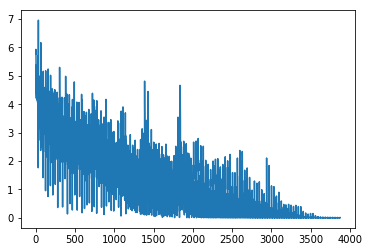

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))